In [ ]:
# Google Colab에서 노트북을 실행하실 때에는 
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline

마리오 게임 RL 에이전트로 학습하기
==================================

**Authors**: [Yuansong Feng](https://github.com/YuansongFeng), [Suraj Subramanian](https://github.com/suraj813), [Howard Wang](https://github.com/hw26), [Steven Guo](https://github.com/GuoYuzhang).

:   **번역**: [김태영](https://github.com/Taeyoung96).

이번 튜토리얼에서는 심층 강화 학습의 기본 사항들에 대해 이야기해보도록
하겠습니다. 마지막에는, 스스로 게임을 할 수 있는 AI 기반 마리오를
([Double Deep Q-Networks](https://arxiv.org/pdf/1509.06461.pdf) 사용)
구현하게 됩니다.

이 튜토리얼에서는 RL에 대한 사전 지식이 필요하지 않지만, 이러한
[링크](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)
를 통해 RL 개념에 친숙해 질 수 있으며, 여기 있는
[치트시트](https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N)
를 활용할 수도 있습니다. 튜토리얼에서 사용하는 전체 코드는
[여기](https://github.com/yuansongFeng/MadMario/) 에서 확인 할 수
있습니다.

![](https://tutorials.pytorch.kr/_static/img/mario.gif)


``` {.sourceCode .bash}
%%bash
pip install gym-super-mario-bros==7.4.0
pip install tensordict==0.3.0
pip install torchrl==0.3.0
```


In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, time, os

# Gym은 강화학습을 위한 OpenAI 툴킷입니다.
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# OpenAI Gym을 위한 NES 에뮬레이터
from nes_py.wrappers import JoypadSpace

# OpenAI Gym에서의 슈퍼 마리오 환경 세팅
import gym_super_mario_bros

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

강화학습 개념
=============

**환경(Environment)** : 에이전트가 상호작용하며 스스로 배우는
세계입니다.

**행동(Action)** $a$ : 에이전트가 환경에 어떻게 응답하는지 행동을 통해
나타냅니다. 가능한 모든 행동의 집합을 *행동 공간* 이라고 합니다.

**상태(State)** $s$ : 환경의 현재 특성을 상태를 통해 나타냅니다. 환경이
있을 수 있는 모든 가능한 상태 집합을 *상태 공간* 이라고 합니다.

**포상(Reward)** $r$ : 포상은 환경에서 에이전트로 전달되는 핵심
피드백입니다. 에이전트가 학습하고 향후 행동을 변경하도록 유도하는
것입니다. 여러 시간 단계에 걸친 포상의 합을 **리턴(Return)** 이라고
합니다.

**최적의 행동-가치 함수(Action-Value function)** $Q^*(s,a)$ : 상태 $s$
에서 시작하면 예상되는 리턴을 반환하고, 임의의 행동 $a$ 를 선택합니다.
그리고 각각의 미래의 단계에서 포상의 합을 극대화하는 행동을 선택하도록
합니다. $Q$ 는 상태에서 행동의 "품질" 을 나타냅니다. 우리는 이 함수를
근사 시키려고 합니다.


환경(Environment)
=================

환경 초기화하기
---------------

마리오 게임에서 환경은 튜브, 버섯, 그 이외 다른 여러 요소들로 구성되어
있습니다.

마리오가 행동을 취하면, 환경은 변경된 (다음)상태, 포상 그리고 다른
정보들로 응답합니다.


### detail setting
<br/> SuperMarioBros-"world"-"stage"-v"version"
<br>"world" is a number in {1, 2, 3, 4, 5, 6, 7, 8} indicating the world
<br>"stage" is a number in {1, 2, 3, 4} indicating the stage within a world
<br>"version" is a number in {0, 1, 2, 3} specifying the ROM mode to use

<br>0: standard ROM
<br>1: downsampled ROM
<br>2: pixel ROM
<br>3: rectangle ROM

In [2]:
# 슈퍼 마리오 환경 초기화하기 (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    try:
        env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='human', apply_api_compatibility=True)
    except:
        env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb-array', apply_api_compatibility=True)

# 상태 공간을 3가지로 제한하기
#   0. 오른쪽으로 걷기
#   1. 오른쪽으로 점프하기
#   2. 
env = JoypadSpace(env, [["right"], ["right", "A"], ["A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

/Users/bagjuhyeon/Documents/WorkSpace/RL-game/.venv/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/bagjuhyeon/Documents/WorkSpace/RL-game/.venv/lib/python3.10/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


환경 전처리 과정 거치기
=======================

`다음 상태(next_state)` 에서 환경 데이터가 에이전트로 반환됩니다. 앞서
살펴보았듯이, 각각의 상태는 `[3, 240, 256]` 의 배열로 나타내고 있습니다.
종종 상태가 제공하는 것은 에이전트가 필요로 하는 것보다 더 많은
정보입니다. 예를 들어, 마리오의 행동은 파이프의 색깔이나 하늘의 색깔에
좌우되지 않습니다!

아래에 설명할 클래스들은 환경 데이터를 에이전트에 보내기 전 단계에서
전처리 과정에 사용할 **래퍼(Wrappers)** 입니다.

`GrayScaleObservation` 은 RGB 이미지를 흑백 이미지로 바꾸는 일반적인
래퍼입니다. `GrayScaleObservation` 클래스를 사용하면 유용한 정보를 잃지
않고 상태의 크기를 줄일 수 있습니다. `GrayScaleObservation` 를 적용하면
각각 상태의 크기는 `[1, 240, 256]` 이 됩니다.

`ResizeObservation` 은 각각의 상태(Observation)를 정사각형 이미지로 다운
샘플링합니다. 이 래퍼를 적용하면 각각 상태의 크기는 `[1, 84, 84]` 이
됩니다.

`SkipFrame` 은 `gym.Wrapper` 으로부터 상속을 받은 사용자 지정
클래스이고, `step()` 함수를 구현합니다. 왜냐하면 연속되는 프레임은 큰
차이가 없기 때문에 n개의 중간 프레임을 큰 정보의 손실 없이 건너뛸 수
있기 때문입니다. n번째 프레임은 건너뛴 각 프레임에 걸쳐 누적된 포상을
집계합니다.

`FrameStack` 은 환경의 연속 프레임을 단일 관찰 지점으로 바꾸어 학습
모델에 제공할 수 있는 래퍼입니다. 이렇게 하면 마리오가 착지 중이였는지
또는 점프 중이었는지 이전 몇 프레임의 움직임 방향에 따라 확인할 수
있습니다.


In [3]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """모든 `skip` 프레임만 반환합니다."""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """행동을 반복하고 포상을 더합니다."""
        total_reward = 0.0
        for i in range(self._skip):
            # 포상을 누적하고 동일한 작업을 반복합니다.
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # [H, W, C] 배열을 [C, H, W] 텐서로 바꿉니다.
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# 래퍼를 환경에 적용합니다.
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

앞서 소개한 래퍼를 환경에 적용한 후, 최종 래핑 상태는 왼쪽 아래 이미지에
표시된 것처럼 4개의 연속된 흑백 프레임으로 구성됩니다. 마리오가 행동을
할 때마다, 환경은 이 구조의 상태로 응답합니다. 구조는 `[4, 84, 84]`
크기의 3차원 배열로 구성되어 있습니다.

![](https://tutorials.pytorch.kr/_static/img/mario_env.png)


에이전트(Agent)
===============

`Mario` 라는 클래스를 이 게임의 에이전트로 생성합니다. 마리오는 다음과
같은 기능을 할 수 있어야 합니다.

-   **행동(Act)** 은 (환경의) 현재 상태를 기반으로 최적의 행동 정책에
    따라 정해집니다.
-   경험을 **기억(Remember)** 하는 것. 경험은 (현재 상태, 현재 행동,
    포상, 다음 상태) 로 이루어져 있습니다. 마리오는 그의 행동 정책을
    업데이트 하기 위해 *캐시(caches)* 를 한 다음, 그의 경험을
    *리콜(recalls)* 합니다.
-   **학습(Learn)** 을 통해 시간이 지남에 따라 더 나은 행동 정책을
    택합니다.


In [4]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """상태가 주어지면, 입실론-그리디 행동(epsilon-greedy action)을 선택해야 합니다."""
        pass

    def cache(self, experience):
        """메모리에 경험을 추가합니다."""
        pass

    def recall(self):
        """메모리로부터 경험을 샘플링합니다."""
        pass

    def learn(self):
        """일련의 경험들로 실시간 행동 가치(online action value) (Q) 함수를 업데이트 합니다."""
        pass

이번 섹션에서는 마리오 클래스의 매개변수를 채우고, 마리오 클래스의
함수들을 정의하겠습니다.


행동하기(Act)
=============

주어진 상태에 대해, 에이전트는 최적의 행동을 이용할 것인지 임의의 행동을
선택하여 분석할 것인지 선택할 수 있습니다.

마리오는 임의의 행동을 선택했을 때 `self.exploration_rate` 를
활용합니다. 최적의 행동을 이용한다고 했을 때, 그는 최적의 행동을
수행하기 위해 (`학습하기(Learn)` 섹션에서 구현된) `MarioNet` 이
필요합니다.


In [5]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        if torch.backends.mps.is_available():
            self.device = "mps"
        elif torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"

        # 마리오의 DNN은 최적의 행동을 예측합니다 - 이는 학습하기 섹션에서 구현합니다.
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        #self.exploration_rate_decay = 0.99999975
        self.exploration_rate_decay = 0.99
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e4  # Mario Net 저장 사이의 경험 횟수

    def act(self, state):
        """
    주어진 상태에서, 입실론-그리디 행동(epsilon-greedy action)을 선택하고, 스텝의 값을 업데이트 합니다.

    입력값:
    state (``LazyFrame``): 현재 상태에서의 단일 상태(observation)값을 말합니다. 차원은 (state_dim)입니다.
    출력값:
    ``action_idx`` (int): Mario가 수행할 행동을 나타내는 정수 값입니다.
    """
        # 임의의 행동을 선택하기
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # 최적의 행동을 이용하기
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # exploration_rate 감소하기
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # 스텝 수 증가하기
        self.curr_step += 1
        return action_idx

캐시(Cache)와 리콜(Recall)하기
==============================

이 두가지 함수는 마리오의 "메모리" 프로세스 역할을 합니다.

`cache()`: 마리오가 행동을 할 때마다, 그는 `경험` 을 그의 메모리에
저장합니다. 그의 경험에는 현재 *상태* 에 따른 수행된 *행동* ,
행동으로부터 얻은 *포상* , *다음 상태*, 그리고 게임 *완료* 여부가
포함됩니다.

`recall()`: Mario는 자신의 기억에서 무작위로 일련의 경험을 샘플링하여
게임을 학습하는 데 사용합니다.


In [6]:
class Mario(Mario):  # 연속성을 위한 하위 클래스입니다.
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000, device=torch.device("cpu")))
        self.batch_size = 128

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        입력값:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        메모리에서 일련의 경험들을 검색합니다.
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

학습하기(Learn)
===============

마리오는 [DDQN 알고리즘](https://arxiv.org/pdf/1509.06461) 을
사용합니다. DDQN 두개의 ConvNets ( $Q_{online}$ 과 $Q_{target}$ ) 을
사용하고, 독립적으로 최적의 행동-가치 함수에 근사시키려고 합니다.

구현을 할 때, 특징 생성기에서 `특징들` 을 $Q_{online}$ 와 $Q_{target}$
에 공유합니다. 그러나 각각의 FC 분류기는 가지고 있도록 설계합니다.
$\theta_{target}$ ($Q_{target}$ 의 매개변수 값) 는 역전파에 의해 값이
업데이트 되지 않도록 고정되었습니다. 대신, $\theta_{online}$ 와
주기적으로 동기화를 진행합니다. 이것에 대해서는 추후에 다루도록
하겠습니다.)

신경망
------


In [7]:
class MarioNet(nn.Module):
    """작은 CNN 구조
  입력 -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> 출력
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target 매개변수 값은 고정시킵니다.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

TD 추정 & TD 목표값
===================

학습을 하는데 두 가지 값들이 포함됩니다.

**TD 추정** - 주어진 상태 $s$ 에서 최적의 예측 $Q^*$.

$${TD}_e = Q_{online}^*(s,a)$$

**TD 목표** - 현재의 포상과 다음상태 $s'$ 에서 추정된 $Q^*$ 의 합.

$$a' = argmax_{a} Q_{online}(s', a)$$

$${TD}_t = r + \gamma Q_{target}^*(s',a')$$

다음 행동 $a'$ 가 어떨지 모르기 때문에 다음 상태 $s'$ 에서 $Q_{online}$
값이 최대가 되도록 하는 행동 $a'$ 를 사용합니다.

여기에서 변화도 계산을 비활성화하기 위해 `td_target()` 에서
[\@torch.no\_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)
데코레이터(decorator)를 사용합니다. ($\theta_{target}$ 의 역전파 계산이
필요로 하지 않기 때문입니다.)


In [8]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        # discount_factor <- greedy 하게 해도 충분히 좋지 않을까? 당장 안 죽는게 더 중요하잖아.
        self.gamma = 0.7

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

모델 업데이트
=============

마리오가 재생 버퍼에서 입력을 샘플링할 때, $TD_t$ 와 $TD_e$ 를
계산합니다. 그리고 이 손실을 이용하여 $Q_{online}$ 역전파하여 매개변수
$\theta_{online}$ 를 업데이트합니다. ($\alpha$ 는 `optimizer` 에
전달되는 학습률 `lr` 입니다.)

$$\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)$$

$\theta_{target}$ 은 역전파를 통해 업데이트 되지 않습니다. 대신,
주기적으로 $\theta_{online}$ 의 값을 $\theta_{target}$ 로 복사합니다.

$$\theta_{target} \leftarrow \theta_{online}$$


In [9]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

체크포인트 저장
===============


In [10]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

모든 기능을 합치기
==================


In [11]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # 학습을 진행하기 전 최소한의 경험값.
        self.learn_every = 3  # Q_online 업데이트 사이의 경험 횟수.
        self.sync_every = 1e4  # Q_target과 Q_online sync 사이의 경험 수

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # 메모리로부터 샘플링을 합니다.
        state, next_state, action, reward, done = self.recall()

        # TD 추정값을 가져옵니다.
        td_est = self.td_estimate(state, action)

        # TD 목표값을 가져옵니다.
        td_tgt = self.td_target(reward, next_state, done)

        # 실시간 Q(Q_online)을 통해 역전파 손실을 계산합니다.
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

기록하기
========


In [12]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )

         # 텐서보드 writer 초기화
        self.writer = SummaryWriter(log_dir=str(save_dir / "tensorboard"))
        
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # 지표(Metric)와 관련된 리스트입니다.
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # 모든 record() 함수를 호출한 후 이동 평균(Moving average)을 계산합니다.
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # 현재 에피스드에 대한 지표를 기록합니다.
        self.init_episode()

        # 시간에 대한 기록입니다.
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "에피스드의 끝을 표시합니다."
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)

        # 텐서보드에 기록
        self.writer.add_scalar('Metrics/Mean Reward', mean_ep_reward, episode)
        self.writer.add_scalar('Metrics/Mean Length', mean_ep_length, episode)
        self.writer.add_scalar('Metrics/Mean Loss', mean_ep_loss, episode)
        self.writer.add_scalar('Metrics/Mean Q Value', mean_ep_q, episode)
        self.writer.add_scalar('Metrics/Epsilon', epsilon, episode)
        
        # 이동 평균
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))
    def close(self):
        self.writer.close()

게임을 실행시켜봅시다!
======================

이번 예제에서는 40개의 에피소드에 대해 학습 루프를 실행시켰습니다.하지만
마리오가 진정으로 세계를 학습하기 위해서는 적어도 40000개의 에피소드에
대해 학습을 시킬 것을 제안합니다!


Using CUDA: False

Episode 0 - Step 113 - Epsilon 0.3212010745647914 - Mean Reward 614.0 - Mean Length 113.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 2.033 - Time 2025-05-12T21:02:42
Episode 20 - Step 11816 - Epsilon 0.1 - Mean Reward 424.19 - Mean Length 562.667 - Mean Loss 0.104 - Mean Q Value 0.402 - Time Delta 226.283 - Time 2025-05-12T21:06:29
Episode 40 - Step 15942 - Epsilon 0.1 - Mean Reward 607.683 - Mean Length 388.829 - Mean Loss 0.134 - Mean Q Value 0.851 - Time Delta 110.379 - Time 2025-05-12T21:08:19
Episode 60 - Step 19053 - Epsilon 0.1 - Mean Reward 637.098 - Mean Length 312.344 - Mean Loss 0.145 - Mean Q Value 1.193 - Time Delta 83.72 - Time 2025-05-12T21:09:43
Episode 80 - Step 21715 - Epsilon 0.1 - Mean Reward 644.321 - Mean Length 268.086 - Mean Loss 0.163 - Mean Q Value 1.723 - Time Delta 70.457 - Time 2025-05-12T21:10:53
Episode 100 - Step 25110 - Epsilon 0.1 - Mean Reward 669.75 - Mean Length 249.97 - Mean Loss 0.171 - Mean Q Value 2.277 - Time Delta 91.05

KeyboardInterrupt: 

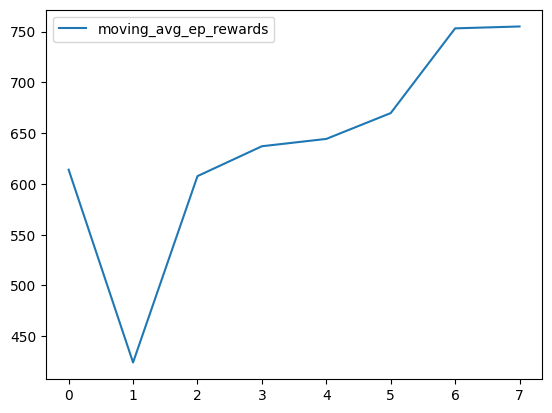

In [13]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 40000
for e in range(episodes):

    state = env.reset()

    # 게임을 실행시켜봅시다!
    while True:

        # 현재 상태에서 에이전트 실행하기
        action = mario.act(state)

        # 에이전트가 액션 수행하기
        next_state, reward, done, trunc, info = env.step(action)

        # 기억하기
        mario.cache(state, next_state, action, reward, done)

        # 배우기
        q, loss = mario.learn()

        # 기록하기
        logger.log_step(reward, loss, q)

        # 상태 업데이트하기
        state = next_state

        # 게임이 끝났는지 확인하기
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)
logger.close()

In [ ]:
import torch.multiprocessing as mp
from torch.multiprocessing import Process, Queue
import numpy as np
import time

class ParallelEnv:
    def __init__(self, num_envs=4):
        self.num_envs = num_envs
        self.envs = []
        self.queues = []
        
        for _ in range(num_envs):
            env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb-array', apply_api_compatibility=True)
            env = JoypadSpace(env, [["right"], ["right", "A"]])
            env = SkipFrame(env, skip=4)
            env = GrayScaleObservation(env)
            env = ResizeObservation(env, shape=84)
            env = FrameStack(env, num_stack=4)
            self.envs.append(env)
            self.queues.append(Queue())
    
    def reset(self):
        states = []
        for env in self.envs:
            state = env.reset()
            states.append(state)
        return states
    
    def step(self, actions):
        states = []
        rewards = []
        dones = []
        infos = []
        
        for i, (env, action) in enumerate(zip(self.envs, actions)):
            state, reward, done, trunc, info = env.step(action)
            states.append(state)
            rewards.append(reward)
            dones.append(done)
            infos.append(info)
            
            if done:
                state = env.reset()
                states[i] = state
        
        return states, rewards, dones, infos

def train_worker(worker_id, shared_memory, num_episodes):
    # 각 워커별 환경 초기화
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb-array', apply_api_compatibility=True)
    env = JoypadSpace(env, [["right"], ["right", "A"]])
    env = SkipFrame(env, skip=4)
    env = GrayScaleObservation(env)
    env = ResizeObservation(env, shape=84)
    env = FrameStack(env, num_stack=4)
    
    # 에이전트 초기화
    mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=Path("checkpoints"))
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        
        while True:
            action = mario.act(state)
            next_state, reward, done, trunc, info = env.step(action)
            
            # 경험 저장
            mario.cache(state, next_state, action, reward, done)
            
            # 학습
            q, loss = mario.learn()
            
            episode_reward += reward
            state = next_state
            
            if done or info["flag_get"]:
                break
        
        # 공유 메모리에 결과 저장
        shared_memory.put({
            'worker_id': worker_id,
            'episode': episode,
            'reward': episode_reward
        })

def main():
    num_workers = 4  # 병렬로 실행할 워커 수
    num_episodes = 10000  # 각 워커당 에피소드 수
    
    # 공유 메모리 초기화
    shared_memory = Queue()
    
    # 워커 프로세스 생성
    processes = []
    for i in range(num_workers):
        p = Process(target=train_worker, args=(i, shared_memory, num_episodes))
        p.start()
        processes.append(p)
    
    # 메인 에이전트 초기화
    mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=Path("checkpoints"))
    logger = MetricLogger(save_dir=Path("checkpoints"))
    
    # 결과 수집 및 로깅
    total_episodes = 0
    while total_episodes < num_workers * num_episodes:
        result = shared_memory.get()
        logger.log_episode()
        logger.record(
            episode=result['episode'],
            epsilon=mario.exploration_rate,
            step=mario.curr_step
        )
        total_episodes += 1
    
    # 프로세스 종료
    for p in processes:
        p.join()
    
    logger.close()

if __name__ == "__main__":
    mp.set_start_method('spawn')  # Windows 호환성을 위해 필요
    main()

결론
====

이 튜토리얼에서는 PyTorch를 사용하여 게임 플레이 AI를 훈련하는 방법을
살펴보았습니다. [OpenAI gym](https://gym.openai.com/) 에 있는 어떤
게임이든 동일한 방법으로 AI를 훈련시키고 게임을 진행할 수 있습니다. 이
튜토리얼이 도움이 되었기를 바라며, [Github
저장소](https://github.com/yuansongFeng/MadMario/) 에서 편하게
저자들에게 연락을 하셔도 됩니다!
